In [29]:
!pip install geocoder
!pip install folium

###### IBM Data Science Capstone Project Final Notebook

In [30]:
#importing necessary libraries
import requests
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")


Libraries imported.


In [35]:
# Latitude and longitude of paris center
lat_tls = 48.864716
lng_tls = 2.349014

In [36]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='EUYZVPW2NCXMYL0BQJDBB0WLFJF4XI3Q4V4MCHQCQKN5T5ZT',
client_secret='TJQJB5WQKR4PKXLMEPFGBRALD5SJE2UTTYCLDJWFFMQDWBSO',
v='20180323',
ll=str(lat_tls) + ',' + str(lng_tls),
    
query='loisirs', 
                 
    
limit=200,
locale='fr',
radius=1800
)

resp = requests.get(url=url, params=params)
data = json.loads(resp.text)
items = data['response']['groups'][0]['items']

In [37]:
#Turn the JSON results into a parsed pandas dataframe.
from pandas import json_normalize

dataframe = json_normalize(items) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

# Drop useless columns
dataframe_filtered.drop(columns=['labeledLatLngs','distance','postalCode','cc','city','state','country','formattedAddress','crossStreet','id'],
                       inplace=True)

dataframe_filtered.head()

,name,categories,address,lat,lng,neighborhood
0,La Gaîté Lyrique,Salle de concert,3 bis rue Papin,48.866673,2.353435,NaN
1,Centre Pompidou – Musée National d'Art Moderne,Musée d'art,Place Georges Pompidou,48.860730,2.351660,NaN
2,Galerie Daniel Templon,Galerie d'art,30 rue Beaubourg,48.862066,2.353825,NaN
3,Comedy Club,Salle de spectacle,42 boulevard de Bonne Nouvelle,48.870646,2.348376,NaN
4,Maison de Nicolas Flamel,Site historique,51 rue de Montmorency,48.863605,2.353130,NaN


In [39]:
print("Number of collected sites :", dataframe_filtered.shape[0])


Number of collected sites : 100


### Data cleaning


In [37]:
#Take a look at all the different categories
cat = dataframe_filtered['categories'].unique()
print("Number of different categories names:", len(cat), '\n\nAll categories:\n', cat)

Number of different categories names: 28 

All categories:
 ['Salle de concert' "Musée d'art" "Galerie d'art" 'Salle de spectacle'
 'Site historique' 'Magasin de vêtements' 'Cinéma indépendant' 'Église'
 'Faculté et université' 'Librairie' 'Club de jazz' 'Jardin' 'Parc'
 'Théâtre' 'Musée' 'Centre culturel' 'Coffee Shop' 'Boutique' 'Opéra'
 "Bar d'hôtel" 'Cirque' 'Place' 'Salle de danse' 'Bâtiment gouvernemental'
 'Auditorium' 'Bar' 'Salle polyvalente' "Salle d'arcade"]


In [41]:
#Group all the dataset categories and build a dict with the new levels.
#Rename all categories in the dataframe with the previous clustering dict.

In [42]:
subcategorie_labels = {
    #  show
    "spectacle": ["Opéra", "Théâtre", "Salle de spectacle", "Complexe des arts de la scène", "Complexe des arts de la\xa0scène"],
    "cinema": ["Multiplexe", "Cinéma indépendant", "Cinéma"],
    "music": ["Salle de concert", "Auditorium"],

    # place
    "monument": ["Hôtel de ville", "Base militaire", "Église", "Site historique"],

    # Play
    "sport": ["Stade de basketball", "Stade de football", "Café des sports", "Salle de danse", "Stade"],
    "game": ["Salle d'arcade", "Parc d'attractions"],

    # Interact with culture
    "exposition-formation": ["Musée d'art", "Musée des sciences", "Galerie d'art", "Musée d'histoire", "École"],

    # Enjoy 
    "parc": ["Parc", "Jardin"]
}

hicategorie_labels = {
    "show": ["spectacle", "cinema", "music"],
    "monument": ["monument"],
    "play": ["sport", "game", "parc"],
    "exposition-formation": ["exposition-formation"] 
}

In [43]:

# All sub-categories names
for i, cat_val in enumerate(subcategorie_labels.values()):
    filt = list(map(lambda cat_venu: cat_venu in cat_val,
                    dataframe_filtered['categories']))
    dataframe_filtered.loc[filt,'categories'] = list(subcategorie_labels.keys())[i]

In [44]:
# All higher-categories names
for i, cat_val in enumerate(hicategorie_labels.values()):
    filt = list(map(lambda cat_venu: cat_venu in cat_val,
                    dataframe_filtered['categories']))
    dataframe_filtered.loc[filt,'hicategories'] = list(hicategorie_labels.keys())[i]

In [42]:
# Take a look at all the different categories
cat = dataframe_filtered['categories'].unique()
hicat = dataframe_filtered['hicategories'].unique()
print("Number of different sub-categories names:", len(cat), '\nAll catefories:\n', cat, '\n\n',
     "Number of different higher-categories names:", len(hicat), '\nAll catefories:\n', hicat)

Number of different sub-categories names: 22 
All catefories:
 ['music' 'exposition-formation' 'spectacle' 'monument'
 'Magasin de vêtements' 'cinema' 'Faculté et université' 'Librairie'
 'Club de jazz' 'parc' 'Musée' 'Centre culturel' 'Coffee Shop' 'Boutique'
 "Bar d'hôtel" 'Cirque' 'Place' 'sport' 'Bâtiment gouvernemental' 'Bar'
 'Salle polyvalente' 'game'] 

 Number of different higher-categories names: 5 
All catefories:
 ['show' 'exposition-formation' 'monument' nan 'play']


In [45]:
dataframe_filtered.head()


,name,categories,address,lat,lng,neighborhood,hicategories
0,La Gaîté Lyrique,music,3 bis rue Papin,48.866673,2.353435,NaN,show
1,Centre Pompidou – Musée National d'Art Moderne,exposition-formation,Place Georges Pompidou,48.860730,2.351660,NaN,exposition-formation
2,Galerie Daniel Templon,exposition-formation,30 rue Beaubourg,48.862066,2.353825,NaN,exposition-formation
3,Comedy Club,spectacle,42 boulevard de Bonne Nouvelle,48.870646,2.348376,NaN,show
4,Maison de Nicolas Flamel,monument,51 rue de Montmorency,48.863605,2.353130,NaN,monument


In [44]:
print("Sub-categories occurrence:\n" , dataframe_filtered['categories'].value_counts(),
     "\n\nHigher categories occurrence:\n", dataframe_filtered['hicategories'].value_counts())

Sub-categories occurrence:
 exposition-formation       29
spectacle                  13
monument                   11
parc                       11
cinema                      7
music                       6
Club de jazz                4
Centre culturel             3
Musée                       3
Cirque                      1
Bâtiment gouvernemental     1
Boutique                    1
Bar                         1
Place                       1
Coffee Shop                 1
Magasin de vêtements        1
Salle polyvalente           1
Bar d'hôtel                 1
Librairie                   1
game                        1
Faculté et université       1
sport                       1
Name: categories, dtype: int64 

Higher categories occurrence:
 exposition-formation    29
show                    26
play                    13
monument                11
Name: hicategories, dtype: int64


###### visualization

In [48]:
import folium

paris_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#205E40',
        fill=True,
        opacity=0,
        fill_color='#ffa089',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_map)

paris_map

###### Category color distinction

In [49]:
from matplotlib import cm

keys = list(dataframe_filtered['categories'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))

colors = [cm.colors.to_hex(cm.tab10(x)) for x in color_range]
color_dict = dict(zip(keys, colors))

In [50]:
categories = dataframe_filtered['categories'].unique()
folium_lgd = dict()
for col, cat in zip(colors, categories):
    folium_lgd[cat] = folium.FeatureGroup(name='<span style=\\"color: {col};\\">{cat}</span>'.format(col=col, cat=cat))

In [51]:
paris_map = folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

for lat, lng, name, cat in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],
                               dataframe_filtered['name'], dataframe_filtered['categories']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        fill=True,
        opacity=0,
        fill_color=color_dict[cat],
        fill_opacity=0.8,
        parse_html=False).add_to(folium_lgd[cat])
    folium_lgd[cat].add_to(paris_map)

folium.map.LayerControl('topright', collapsed=False).add_to(paris_map)
    
paris_map

In [4]:
import sys
'geopandas' in sys.modules

False

In [7]:
conda install ipython

Solving environment: ...working... done

## Package Plan ##

Note: you may need to restart the kernel to use updated packages.

  environment location: C:\Users\LENOVO\anaconda3

  added / updated specs:
    - ipython


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py38haa95532_1         2.9 MB
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following packages will be UPDATED:

  conda              conda-forge::conda-4.9.2-py38haa244fe~ --> pkgs/main::conda-4.10.1-py38haa95532_1




conda-4.10.1         | 2.9 MB    |            |   0% 
conda-4.10.1         | 2.9 MB    |            |   1% 
conda-4.10.1         | 2.9 MB    | 1          |   2% 
conda-4.10.1         | 2.9 MB    | 5          |   5% 
conda-4.10.1         | 2.9 MB    | #          |  10% 
conda-4.10.1         |

 #######paris dataset

In [87]:
#### Download and read data

import pandas as pd
paris_venus = pd.read_csv('paris-attraction.csv')
paris_venus.head()

,address,category,id,lat,lng,location,name,originalId,polarity,subCategory,details,reviews
0,8 rue de Navarin,attraction,83256,48.87961034033,2.3393825451216,Paris,Hôtel Amour,4ac79395f964a52021b820e3,0,Hotel Bar,http://tour-pedia.org/api/getPlaceDetails?id=8...,http://tour-pedia.org/api/getReviewsByPlaceId?...
1,49 Rue Pierre Charron,attraction,83321,48.869145508329,2.3021912516801,Paris,Pershing Hall,4adcda03f964a520c03121e3,0,Hotel,http://tour-pedia.org/api/getPlaceDetails?id=8...,http://tour-pedia.org/api/getReviewsByPlaceId?...
2,99 rue Oberkampf,attraction,83355,48.8654975,2.3766887,Paris,Mécano-Bar,4adcda04f964a520333221e3,0,Bar,http://tour-pedia.org/api/getPlaceDetails?id=8...,http://tour-pedia.org/api/getReviewsByPlaceId?...
3,1 rue Théophile Roussel,attraction,83358,48.849622701075,2.377436673654,Paris,Le Baron Rouge,4adcda04f964a520393221e3,0,Wine Bar,http://tour-pedia.org/api/getPlaceDetails?id=8...,http://tour-pedia.org/api/getReviewsByPlaceId?...
4,7-15 Avenue de la Porte de la Villette,attraction,83363,48.899198480866,2.3867258494543,Paris,Glazart,4adcda04f964a520473221e3,0,Music Venue,http://tour-pedia.org/api/getPlaceDetails?id=8...,http://tour-pedia.org/api/getReviewsByPlaceId?...


In [88]:
paris_venus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4351 entries, 0 to 4350
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address      3983 non-null   object
 1   category     4351 non-null   object
 2   id           4343 non-null   object
 3   lat          4351 non-null   object
 4   lng          4351 non-null   object
 5   location     4351 non-null   object
 6   name         4351 non-null   object
 7   originalId   4351 non-null   object
 8   polarity     4351 non-null   object
 9   subCategory  1522 non-null   object
 10  details      1522 non-null   object
 11  reviews      1522 non-null   object
dtypes: object(12)
memory usage: 408.0+ KB


In [89]:
paris_venus.shape

(4351, 12)

Data cleaning


In [90]:
# Remove useless features
paris_venus .drop(["polarity", "details","reviews","originalId"], axis=1, inplace=True)

# Overview
paris_venus.head()

,address,category,id,lat,lng,location,name,subCategory
0,8 rue de Navarin,attraction,83256,48.87961034033,2.3393825451216,Paris,Hôtel Amour,Hotel Bar
1,49 Rue Pierre Charron,attraction,83321,48.869145508329,2.3021912516801,Paris,Pershing Hall,Hotel
2,99 rue Oberkampf,attraction,83355,48.8654975,2.3766887,Paris,Mécano-Bar,Bar
3,1 rue Théophile Roussel,attraction,83358,48.849622701075,2.377436673654,Paris,Le Baron Rouge,Wine Bar
4,7-15 Avenue de la Porte de la Villette,attraction,83363,48.899198480866,2.3867258494543,Paris,Glazart,Music Venue


In [91]:
paris_venus.groupby('subCategory').count()

,address,category,id,lat,lng,location,name
subCategory,,,,,,,
Arcade,2,2,2,2,2,2,2
Art Gallery,9,10,10,10,10,10,10
Art Museum,7,9,9,9,9,9,9
Arts & Entertainment,3,4,4,4,4,4,4
Athletics & Sports,8,14,14,14,14,14,14
Auditorium,22,41,41,41,41,41,41
Bar,164,181,181,181,181,181,181
Baseball Field,0,2,2,2,2,2,2
Baseball Stadium,0,1,1,1,1,1,1


In [92]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(paris_venus['category'].unique())))

There are 2766 uniques categories.


In [93]:
#print out the list of subcategories
paris_venus['subCategory'].unique()[:100]

array(['Hotel Bar', 'Hotel', 'Bar', 'Wine Bar', 'Music Venue', 'Pub',
       'Cocktail Bar', 'Sports Bar', 'Nightclub', nan, 'Rock Club',
       'Lounge', 'Church', 'Lake', 'Cemetery', 'Plaza', 'Park',
       'Event Space', 'Temple', 'Mosque', 'Historic Site', 'Garden',
       'Bridge', 'Museum', 'Zoo', 'Spiritual Center', 'Art Museum',
       'Harbor / Marina', 'Racetrack', 'Art Gallery', 'Synagogue',
       'Island', 'History Museum', 'Theater', 'Comedy Club',
       'Concert Hall', 'Strip Club', 'Multiplex', 'Arts & Entertainment',
       'General Entertainment', 'Soccer Field', 'Pool', 'Theme Park',
       'Gym Pool', 'Movie Theater', 'Stadium', 'Gay Bar',
       'Other Great Outdoors', 'Beer Garden', 'Neighborhood',
       'Radio Station', 'Office', 'Performing Arts Venue',
       'Indie Movie Theater', 'Public Art', 'Planetarium', 'Farm',
       'Auditorium', 'Tennis', 'Athletics & Sports', 'Brewery',
       'Scenic Lookout', 'River', 'Opera House', 'Italian Restaurant',
       '

I am a fan of art and history, and Paris is famous for its art galleries

In [94]:
# check if the results contain "art Gallery"


"Art Gallery" in paris_venus['subCategory'].unique()

True

In [95]:
# one hot encoding
to_onehot = pd.get_dummies(paris_venus[['subCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['subCategory'] = paris_venus['subCategory']

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(4351, 121)


,subCategory,Arcade,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Auditorium,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Garden,Bowling Alley,Brewery,Bridge,Building,Café,Campground,Cemetery,Church,City,Cocktail Bar,College Quad,Comedy Club,Concert Hall,Coworking Space,Dance Studio,Dive Bar,Dog Run,Event Space,Farm,Field,Football Stadium,French Restaurant,Garden,Gay Bar,General Entertainment,Golf Course,Gym,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home (private),Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Indie Movie Theater,Indie Theater,Internet Cafe,Island,Italian Restaurant,Jazz Club,Lake,Lighthouse,Lounge,Military Base,Miscellaneous Shop,Monument / Landmark,Mosque,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Opera House,Other Event,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Park,Performing Arts Venue,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,River,Rock Climbing Spot,Rock Club,Scenic Lookout,School,Science Museum,Sculpture Garden,Shrine,Skate Park,Ski Trail,Soccer Field,Soccer Stadium,Speakeasy,Spiritual Center,Sports Bar,Stables,Stadium,Strip Club,Synagogue,Temple,Tennis,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Track Stadium,Trail,Vineyard,Water Park,Well,Whisky Bar,Wine Bar,Zoo
0,Hotel Bar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hotel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bar,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wine Bar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Music Venue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Next, let's group rows by category and by taking the mean of the frequency of occurrence of each category



In [81]:
to_grouped = to_onehot.groupby(["subCategory"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(120, 121)


,subCategory,Arcade,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Auditorium,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Garden,Bowling Alley,Brewery,Bridge,Building,Café,Campground,Cemetery,Church,City,Cocktail Bar,College Quad,Comedy Club,Concert Hall,Coworking Space,Dance Studio,Dive Bar,Dog Run,Event Space,Farm,Field,Football Stadium,French Restaurant,Garden,Gay Bar,General Entertainment,Golf Course,Gym,Gym Pool,Harbor / Marina,Historic Site,History Museum,Home (private),Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Indie Movie Theater,Indie Theater,Internet Cafe,Island,Italian Restaurant,Jazz Club,Lake,Lighthouse,Lounge,Military Base,Miscellaneous Shop,Monument / Landmark,Mosque,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Opera House,Other Event,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Park,Performing Arts Venue,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,River,Rock Climbing Spot,Rock Club,Scenic Lookout,School,Science Museum,Sculpture Garden,Shrine,Skate Park,Ski Trail,Soccer Field,Soccer Stadium,Speakeasy,Spiritual Center,Sports Bar,Stables,Stadium,Strip Club,Synagogue,Temple,Tennis,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Track Stadium,Trail,Vineyard,Water Park,Well,Whisky Bar,Wine Bar,Zoo
0,Arcade,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Art Gallery,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Art Museum,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arts & Entertainment,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Athletics & Sports,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Auditorium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Bar,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Baseball Field,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Baseball Stadium,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Basketball Court,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
len(to_grouped[to_grouped["Art Gallery"] > 0])


1

In [97]:
#Create a new dataframe to find Art Gallery


to_art = to_grouped[["subCategory","Art Gallery"]]
to_art.head()

,subCategory,Art Gallery
0,Arcade,0
1,Art Gallery,1
2,Art Museum,0
3,Arts & Entertainment,0
4,Athletics & Sports,0


<AxesSubplot:ylabel='Frequency'>

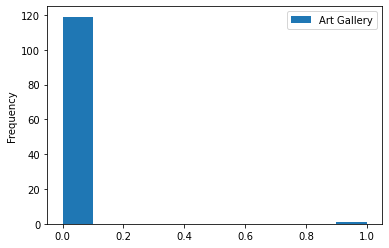

In [137]:
to_art.plot.hist()

In [79]:
!pip3 install KMeans


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\LENOVO\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\LENOVO\\AppData\\Local\\Temp\\pip-install-vfdto1cq\\kmeans\\setup.py'"'"'; __file__='"'"'C:\\Users\\LENOVO\\AppData\\Local\\Temp\\pip-install-vfdto1cq\\kmeans\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\LENOVO\AppData\Local\Temp\pip-wheel-qkzjb_r0'
       cwd: C:\Users\LENOVO\AppData\Local\Temp\pip-install-vfdto1cq\kmeans\
  Complete output (19 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\kmeans
  copying kmeans\performance.py -> build\lib.win-amd64-3.8\kmeans
  copying kmeans\tests.py -> build\lib.win-amd64-3.8\kmeans
  copying kmeans\__init__.py -> build\li


  Running setup.py clean for KMeans
Failed to build KMeans
    Running setup.py install for KMeans: started
    Running setup.py install for KMeans: finished with status 'error'


###### ClusterCategory

Run k-means to cluster careogry in paris into  clusters.



In [98]:
# set number of clusters
from sklearn.cluster import KMeans
toclusters = 3

to_clustering = to_art.drop(["subCategory"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

<ipython-input-98-e16305aee8b1>:8: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each subCategory
to_merged = to_art.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [100]:
to_merged.rename(columns={"subCategory": "subCategory"}, inplace=True)
to_merged.head()

,subCategory,Art Gallery,Cluster Labels
0,Arcade,0,0
1,Art Gallery,1,1
2,Art Museum,0,0
3,Arts & Entertainment,0,0
4,Athletics & Sports,0,0


In [101]:
# merge paris_grouped with toronto_data to add latitude/longitude for each subcatgory
to_merged = to_merged.join(paris_venus.set_index("subCategory"), on="subCategory")

print(to_merged.shape)
to_merged.head()

(1522, 10)


,subCategory,Art Gallery,Cluster Labels,address,category,id,lat,lng,location,name
0,Arcade,0,0,10 rue des Immeubles Industriels,attraction,87572,48.84953114483,2.3928544226342,Paris,Arcade Street
0,Arcade,0,0,Cour Bérard,attraction,91835,48.854308646341,2.3662394285202,Paris,#Appartement4
1,Art Gallery,1,1,Parc de la Villette,attraction,83573,48.890631905558,2.3900761307413,Paris,Pavillon Paul Delouvrier
1,Art Gallery,1,1,7 rond-point des Champs-Élysées,attraction,83609,48.868614071405,2.3088401556015,Paris,Artcurial
1,Art Gallery,1,1,60 Rue de Bassano,attraction,84235,48.871659203246,2.3003911972046,Paris,Espace Culturel Louis Vuitton


In [102]:

to_merged.drop(["location", "id","category"], axis=1, inplace=True)

In [103]:
to_merged

,subCategory,Art Gallery,Cluster Labels,address,lat,lng,name
0,Arcade,0,0,10 rue des Immeubles Industriels,48.84953114483,2.3928544226342,Arcade Street
0,Arcade,0,0,Cour Bérard,48.854308646341,2.3662394285202,#Appartement4
1,Art Gallery,1,1,Parc de la Villette,48.890631905558,2.3900761307413,Pavillon Paul Delouvrier
1,Art Gallery,1,1,7 rond-point des Champs-Élysées,48.868614071405,2.3088401556015,Artcurial
1,Art Gallery,1,1,60 Rue de Bassano,48.871659203246,2.3003911972046,Espace Culturel Louis Vuitton
1,Art Gallery,1,1,2 Rue Charles Nodier,48.884372979613,2.3449059296629,Marché Saint-Pierre
1,Art Gallery,1,1,48 Rue Vieille du Temple,48.858238266037,2.358552493322,L'Espace des Blancs-Manteaux
1,Art Gallery,1,1,7bis rue René Goscinny,48.830801685139,2.3801647866044,Galerie Itinerrance
1,Art Gallery,1,1,12 rue Cantagrel,48.823472446056,2.3764735307265,Cité-Refuge De L'Armée Du Salut Le Corbusier
1,Art Gallery,1,1,Berges de Seine,48.862290116178,2.2987466597392,Photoquai


(1522, 7)


<AxesSubplot:ylabel='Frequency'>

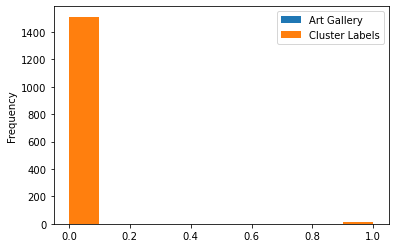

In [136]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.plot.hist()

In [105]:
to_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522 entries, 0 to 1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subCategory     1522 non-null   object
 1   Art Gallery     1522 non-null   uint8 
 2   Cluster Labels  1522 non-null   int32 
 3   address         1154 non-null   object
 4   lat             1522 non-null   object
 5   lng             1522 non-null   object
 6   name            1522 non-null   object
dtypes: int32(1), object(5), uint8(1)
memory usage: 78.8+ KB


Visualize the clusters

In [107]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
# create map
map_clusters = folium.Map(location=[lat_tls, lng_tls], zoom_start=15)
 #folium.Map(location=[lat_tls, lng_tls], zoom_start=15, tiles="cartoDB positron")

# set color scheme for the clusters
x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['lat'], to_merged['lng'], to_merged['subCategory'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [117]:
#Cluster 0
to_merged.loc[to_merged['Cluster Labels'] == 0]

,subCategory,Art Gallery,Cluster Labels,address,lat,lng,name
0,Arcade,0,0,10 rue des Immeubles Industriels,48.84953114483,2.3928544226342,Arcade Street
75,Park,0,0,NaN,48.836280858015,2.4552151246995,Les Maisons Rouges
75,Park,0,0,Port Saint-Bernard,48.848202844791,2.360079510171,Quais de Jussieu
75,Park,0,0,"Jardin Shakespeare, Pré Catelan, Bois de Boulogne",48.864258613048,2.252099692121,Théâtre de Verdure
75,Park,0,0,NaN,48.83922,2.422451,Square Du Jeu De Boules
75,Park,0,0,Cité Internationale Universitaire,48.818280823802,2.3375344276428,Parc de la Cité Internationale Universitaire
75,Park,0,0,NaN,48.856951019685,2.262720855972,Square Passy
75,Park,0,0,NaN,48.839704287732,2.4332125456009,Square Carnot
75,Park,0,0,NaN,48.869102597237,2.272763,Square Robert Schuman
75,Park,0,0,Paris 11,48.852097392082,2.3857539240271,Parc de la Folie-Titon


In [118]:

#Cluster 1
to_merged.loc[to_merged['Cluster Labels'] == 1]

,subCategory,Art Gallery,Cluster Labels,address,lat,lng,name
1,Art Gallery,1,1,91 Rue De l'assomption,48.855155944824,2.2669901847839,fondation hippocrene
1,Art Gallery,1,1,NaN,48.886913299561,2.3470764160156,La Splendens Factory
1,Art Gallery,1,1,12 rue Cantagrel,48.823472446056,2.3764735307265,Cité-Refuge De L'Armée Du Salut Le Corbusier
1,Art Gallery,1,1,7bis rue René Goscinny,48.830801685139,2.3801647866044,Galerie Itinerrance
1,Art Gallery,1,1,48 Rue Vieille du Temple,48.858238266037,2.358552493322,L'Espace des Blancs-Manteaux
1,Art Gallery,1,1,2 Rue Charles Nodier,48.884372979613,2.3449059296629,Marché Saint-Pierre
1,Art Gallery,1,1,60 Rue de Bassano,48.871659203246,2.3003911972046,Espace Culturel Louis Vuitton
1,Art Gallery,1,1,7 rond-point des Champs-Élysées,48.868614071405,2.3088401556015,Artcurial
1,Art Gallery,1,1,Parc de la Villette,48.890631905558,2.3900761307413,Pavillon Paul Delouvrier
1,Art Gallery,1,1,Berges de Seine,48.862290116178,2.2987466597392,Photoquai


In [129]:
to_merged.groupby('address').count()



,subCategory,Art Gallery,Cluster Labels,lat,lng,name
address,,,,,,
1 Bis Rue de la Forge Royale,1,1,1,1,1,1
1 Boulevard Montmartre,1,1,1,1,1,1
1 Place Alphonse Laveran,1,1,1,1,1,1
1 Place Colette,1,1,1,1,1,1
1 Place de la Porte de Versailles,1,1,1,1,1,1
1 Rue De Colmar,1,1,1,1,1,1
1 Rue Ramey,1,1,1,1,1,1
1 Rue Xaintrailles,1,1,1,1,1,1
1 Rue de Babylone,1,1,1,1,1,1


In [119]:
#Cluster 2
to_merged.loc[to_merged['Cluster Labels'] == 2]

,subCategory,Art Gallery,Cluster Labels,address,lat,lng,name


###### Observations



Most of the art Galleries are in Cluster 1 especially Quai de Valmy,Roland Garros in   lowest (close to zero) in Cluster 2
 so if you from who like art   the best place to visit is Quai de Valmy,Roland Garros 